In [41]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import random
import itertools 
import re
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
#import matplotlib.pyplot as plt
import random
from statistics import mean 
import itertools
import ga 
import math
path_file="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dataset=pd.read_csv(path_file,parse_dates=['data'])
# guariti,infetti,sani, morti 
dataset['asintomatici']= dataset['totale_casi'] * 0.44 
dataset['immuni'] = dataset['dimessi_guariti'] * 0.95  #verificare proporzione
data=dataset[['totale_positivi','dimessi_guariti','deceduti']]#,'immuni','asintomatici'
data_first=pd.read_csv(path_file)['data'][0][:-9]
data_last=pd.read_csv(path_file)['data'][data.shape[0]-1][:-9]
#data['sani']=6036000-data['totale_positivi']

In [70]:
def deriv(y,t,k1,k5,k6):  
    '''set di equazioni differenziali'''
   # k1=1.59606149975276e-09
    Sani            =   y[0]
    Infetti         =   y[1]
   # Asintomatici    =   y[2]
    Morti           =   y[2]
    Guariti         =   y[3]
    #Immuni          =   y[5]
    dSanidt =  -k1*Sani*Infetti #-k2*Sani*Infetti-k3*Sani*Asintomatici- k4*Sani*Asintomatici + k9*Guariti
    dInfettidt = k1*Sani*Infetti-k5*Infetti-k6*Infetti
   # dAsintomaticidt =k2*Sani*Infetti+k4*Sani*Asintomatici-k7*Asintomatici
    dMortidt=k5*Infetti
    dGuaritidt =k6*Infetti#-k8*Guariti-k9*Guariti
    #dImmunidt = k8*Guariti
    return [dSanidt,dInfettidt,dMortidt,dGuaritidt]

In [3]:
def diffusione(parameters,Sani =60359779, Infetti=221,Guariti=1, Morti= 7,Asintomatici=0,orizzonte_temporale_in_gg=data.shape[0]):#immuni
        y0 =  (Sani,Infetti,Guariti,Morti)#,Immuni,Asintomatici
        t = np.arange(0,orizzonte_temporale_in_gg)
        ret = odeint(deriv, y0, t,args=tuple(parameters))
        return(ret)


In [4]:
def generateRandomPopulation(popsize, exp_min, exp_max):               #genero k iniziali 
    pop_init = np.random.uniform(low=exp_min, high=exp_max, size=popsize)
    return(list(pop_init))

In [154]:
def fitness(lista): #fitness da massimizare diamo piu peso ai valori relativi ad infetti nei primi 7 e ultimi 20 giorni
    dfObj = pd.DataFrame(columns=['num', 'mean'])
    for num2 in lista:
        previsti=diffusione(num2)
        df=pd.DataFrame(previsti,columns=['sani','totale_positivi','deceduti','dimessi_guariti'])#,'immuni','asintomatici'
        df=df.drop(columns=['sani'])
        dataframe=((df-data)**2)
        lista=dataframe.values.tolist()
        merged = list(itertools.chain.from_iterable(lista))
        
       # merged[5]=merged[5]*100000
        for el in range(5,24,3):
            merged[el]=merged[el]*100000
        for el in range(125,len(merged),3):
            merged[el]=merged[el]*100000
        #for el in range(60,len(merged),3):
         #   merged[el]=merged[el]*20000
        #for el in range(61,len(merged),3):
         #   merged[el]=merged[el]*30000
        media=1/mean(merged)
        dfObj = dfObj.append({'num': num2, 'mean': media}, ignore_index=True)
        #datas=pd.DataFrame({'idx':list(range(1,len(pop)+1)), 'num':, 'fit':media })
    return dfObj

In [6]:
def rouletteSelection(DF):
    return(np.random.choice(DF['num'], size=2, replace=False, p=DF['mean']/DF['mean'].sum()))

In [72]:
def generateOffspring1(parents):
    stop = random.randint(0,2)
    new = list(parents[0][:stop+1])+ list(parents[1][stop+1:])
    return(new,stop)

def generateOffspring2(parents,stop):
    stop = random.randint(0,1)
    new = list(parents[1][:stop+1])+ list(parents[0][stop+1:])
    return(new)
def swapMutation(elemento,popsize):
    r = random.randint(0,2)
    r2=random.randint(0,2)
    #while r==r2:
     #   r2=random.randint(0,2)
    elemento[r] = elemento[r]* np.random.uniform(0,1.2)
    elemento[r2] = elemento[r2]*np.random.uniform(0,1.2)
    if elemento[r] >1:
        elemento[r] =elemento[r]-1
    #if elemento[r] <0:
     #   elemento[r]=elemento[r]+1
    if elemento[r2] >1:
        elemento[r2] =elemento[r2]-1
    #if elemento[r2] <0:
     #   elemento[r2]=elemento[r2]+1
    return(elemento)

In [73]:
def GA(popSize, crossProb, mutProb, numGenerazioni, exp_min, exp_max):
    popsize=popSize
    best={}
    pop = generateRandomPopulation(popSize, exp_min, exp_max)
    for generazione in range(numGenerazioni):
        newPop = None
        df = fitness(pop)
        massimo=df['mean'].max()
        best[generazione] = {'fit':massimo,'num1':df['num'].iloc[df['mean'].idxmax()]}
       
        df = df.sort_values('mean', ascending=False)
       
        newPop = list(df['num'][:2])
        for i in range(1, int(popSize[0]/2)):
            parents = rouletteSelection(df)
            if (random.uniform(0,1)<=crossProb):
                off1,stop = generateOffspring1(parents)
                off2 = generateOffspring2(parents, stop)
            else:
                off1 = parents[0]
                off2 = parents[1]
            newPop.append(off1)
            newPop.append(off2)
        for i in range(len(newPop)):
            if (random.uniform(0,1)<=mutProb):
                newPop[i]=(swapMutation(newPop[i],popsize[0]))
        pop=newPop
    
    return(best)

In [ ]:
random.seed(123)
#Algoritmo
diz = GA(popSize=(50,3), crossProb=0.85, mutProb=0.2, numGenerazioni=14000, exp_min=0, exp_max=1)

In [146]:
diz[2999]['num1']

[2.6427515503519586e-09, 3.6917147086167e-86, 0.0653959705648147]

i valori migliori trovati con 3000 iterazioni sono [3.5137284291108545e-08,0.999778598118124,09985819873817682]

In [15]:
def grafico(stato):
    d={'Sani':0,'Infetti':1,'Deceduti':2,'Guariti':3}#,'Immuni':5'Asintomatici':2,
    col={'Sani':'b--','Infetti':'r','Asintomatici':'y','Deceduti':'k','Guariti':'g','Immuni':'grey'}
    plt.plot(ret[:,d[stato]], col[stato], alpha=0.7 ,lw=2, label=stato)
    plt.xlabel('Tempo (in giorni)')
    plt.ylabel('Popolazione')
    plt.axvline(data.shape[0],color='grey')
    plt.text(0,ret[:,d[stato]].mean(),data_last)
    plt.legend()
    plt.show()

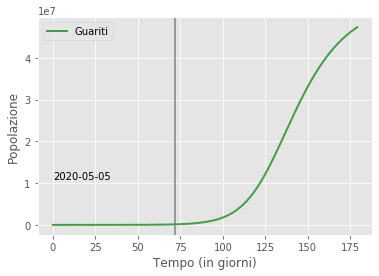

In [152]:
grafico('Guariti')

In [150]:
ret=diffusione(diz[2999]['num1'],orizzonte_temporale_in_gg=180)

In [21]:
ret

array([[120.        , 221.        ,   1.        ,   7.        ],
       [119.99995767, 221.00004233,   1.        ,   7.        ],
       [119.99991534, 221.00008466,   1.        ,   7.        ],
       [119.99987302, 221.00012698,   1.        ,   7.        ],
       [119.99983069, 221.00016931,   1.        ,   7.        ],
       [119.99978836, 221.00021164,   1.        ,   7.        ],
       [119.99974603, 221.00025397,   1.        ,   7.        ],
       [119.99970371, 221.00029629,   1.        ,   7.        ],
       [119.99966138, 221.00033862,   1.        ,   7.        ],
       [119.99961905, 221.00038095,   1.        ,   7.        ],
       [119.99957672, 221.00042328,   1.        ,   7.        ],
       [119.9995344 , 221.0004656 ,   1.        ,   7.        ],
       [119.99949207, 221.00050793,   1.        ,   7.        ],
       [119.99944974, 221.00055026,   1.        ,   7.        ],
       [119.99940741, 221.00059259,   1.        ,   7.        ],
       [119.99936509, 221